## Features:
### DNA features:
- 3-mer frequencies
- GC-content
- sequence length
- start codon (is ATG?)

### Protein features:
- ESM3 embeddings
- protein length

In [2]:
import pandas as pd
import numpy as np
import os
from Bio import SeqIO
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.sparse import hstack

## Import datasets and organize

In [3]:
def fasta_to_df(path):
    """Parses either a folder of FASTA files, or a single FASTA file into a pandas dataframe."""
    data = []

    # Determine if path is a file or folder
    if os.path.isfile(path):
        files = [path]
    elif os.path.isdir(path):
        files = [os.path.join(path, f) for f in os.listdir(path)]

    for file in files:
        for record in SeqIO.parse(file, "fasta"):
            desc = record.description
            ## This is either [gene=_] or [locus_tag=_]
            prot_id = next(  ## For fasta with [protein_id] fields
                (x.split("=")[1][:-1] for x in desc.split() if x.startswith("[gene=")),
                next(
                    (
                        "gene-" + x.split("=")[1][:-1]
                        for x in desc.split()
                        if x.startswith("[locus_tag=")
                    ),
                    None,
                ),
            )
            if prot_id:
                data.append((prot_id, str(record.seq)))

    return pd.DataFrame(data, columns=["id", "sequence"])


def load_dataset(
    dataset_name, phage_accession, gene_classification, aa_fasta, na_fasta
):
    """
    For a dataset with inputs above:
    Return a dataset with columns: gene, classification, aa_seq, na_seq and dataset_name, phage_accession in a tuple
    """
    # Create dataframe for each file
    df_class = pd.read_csv(gene_classification)

    df_proteins = fasta_to_df(aa_fasta)
    df_proteins.rename(columns={"id": "gene", "sequence": "aa_seq"}, inplace=True)

    df_genes = fasta_to_df(na_fasta)
    df_genes.rename(columns={"id": "gene", "sequence": "na_seq"}, inplace=True)

    # Combine dataframes into one on "gene"-column
    df_combined = df_class.merge(df_proteins, on="gene", how="outer").merge(
        df_genes, on="gene", how="outer"
    )

    return df_combined

In [4]:
# Load and combine all datasets listed in accession_list.csv
master_list = pd.read_csv("data/datasets/accession_list.csv")

all_datasets = []

for _, row in master_list.iterrows():
    dataset_name = row["dataset"]
    phage_accession = row["NCBI GenBank accession"]

    gene_classification = f"data/datasets/{dataset_name}/gene_classification.csv"
    aa_fasta = f"data/proteins_aa/{phage_accession}.fasta"
    na_fasta = f"data/proteins_na/{phage_accession}.fasta"

    df = load_dataset(
        dataset_name, phage_accession, gene_classification, aa_fasta, na_fasta
    )
    all_datasets.append(df)

# Combine into one dataframe
df_all = pd.concat(all_datasets, ignore_index=True)
# Drop rows with na values
df_clean = df_all.dropna()

print(f"Dropped {len(df_all) - len(df_clean)} rows.")

# df_clean.to_csv("out.csv")
print(df_clean.shape)

Dropped 49 rows.
(1167, 4)


## Get DNA features

### K-mers

In [5]:
df = df_clean.copy()


def get_kmers(sequence, size=3):
    return [sequence[x : x + size] for x in range(len(sequence) - size + 1)]


df["kmers"] = df["na_seq"].apply(lambda x: " ".join(get_kmers(x, size=3)))

# Convert to numerical feature
vectorizer = CountVectorizer()
# This normalizes for sequence length (TODO: test this)
# from sklearn.feature_extraction.text import TfidfVectorizer
# vectorizer = TfidfVectorizer()

X_kmers = vectorizer.fit_transform(df["kmers"])


kmer_features = vectorizer.get_feature_names_out()
print(f"Number of k-mer features: {len(kmer_features)}")
print(f"First 5 k-mers: {kmer_features[:5]}")

Number of k-mer features: 70
First 5 k-mers: ['aaa' 'aac' 'aag' 'aat' 'aca']


### Others

In [6]:
# GC-content
df["GC_content"] = df["na_seq"].apply(lambda x: (x.count("G") + x.count("C")) / len(x))

# Sequence length
df["gene_length"] = df["na_seq"].apply(len)

# ATG start?
df["start_atg"] = df["na_seq"].apply(lambda x: int(x.startswith("ATG")))

# print(df)

In [7]:
# Combine into final feature matrix
X_other = df[["GC_content", "gene_length", "start_atg"]].values
X = hstack([X_kmers, X_other])

print(X.shape)

(1167, 73)


In [ ]:
# Encode classifications
le = LabelEncoder()
y = le.fit_transform(df["classification"])

# print("Encoded: ", le.fit_transform([0, 1, 2]))
print("Decoded: ", le.inverse_transform([0, 1, 2]))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

Decoded:  ['early' 'late' 'middle']
(933, 73) (933,)
(234, 73) (234,)


In [9]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [ ]:
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(random_state=42),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
]

# Fit each model
trained = [model.fit(X_train, y_train) for model in classifiers]


# clf = RandomForestClassifier(random_state=91)
# clf = KNeighborsClassifier(3)
# clf.fit(X_train, y_train)

In [17]:
for clf, name in zip(trained, names):
    y_pred = clf.predict(X_test)
    print("\n" + name)
    print(classification_report(y_test, y_pred, target_names=le.classes_))

# Evaluate
# y_pred = clf.predict(X_test)
# print(classification_report(y_test, y_pred, target_names=le.classes_))


Nearest Neighbors
              precision    recall  f1-score   support

       early       0.31      0.37      0.34        35
        late       0.69      0.77      0.73       141
      middle       0.44      0.26      0.33        58

    accuracy                           0.59       234
   macro avg       0.48      0.47      0.46       234
weighted avg       0.57      0.59      0.57       234


Linear SVM
              precision    recall  f1-score   support

       early       0.46      0.51      0.49        35
        late       0.70      0.89      0.79       141
      middle       0.31      0.09      0.14        58

    accuracy                           0.64       234
   macro avg       0.49      0.50      0.47       234
weighted avg       0.57      0.64      0.58       234


RBF SVM
              precision    recall  f1-score   support

       early       1.00      0.11      0.21        35
        late       0.62      1.00      0.77       141
      middle       1.00      0.05  

| Metric        | Meaning                                                                                                                                                |
| ------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **precision** | Out of all predicted instances of a class, how many were actually correct?<br>**Formula**: TP / (TP + FP)                                              |
| **recall**    | Out of all actual instances of a class, how many did the model correctly detect?<br>**Formula**: TP / (TP + FN)                                        |
| **f1-score**  | Harmonic mean of precision and recall.<br>Good single metric for imbalanced classes.<br>**Formula**: 2 \* (precision \* recall) / (precision + recall) |
| **support**   | Number of true examples of each class in the dataset.   
|  |  |
| **accuracy**     | Overall: (correct predictions) / (total samples)                                                                                 |
| **macro avg**    | Unweighted average across all classes.<br>Each class contributes equally (good for comparing classes).                           |
| **weighted avg** | Weighted average, where each class's contribution is proportional to its support.<br>More realistic when classes are imbalanced. |


Nearest Neighbors

Linear SVM

RBF SVM

Decision Tree

Random Forest

Neural Net


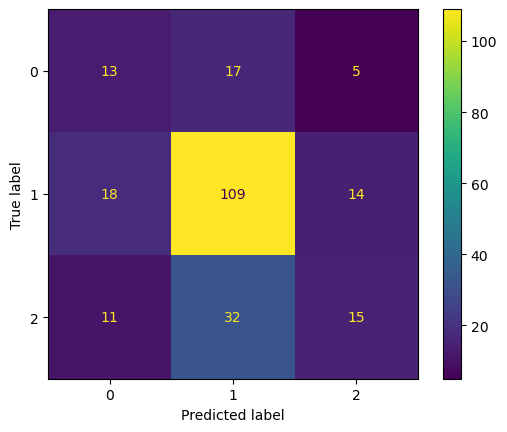

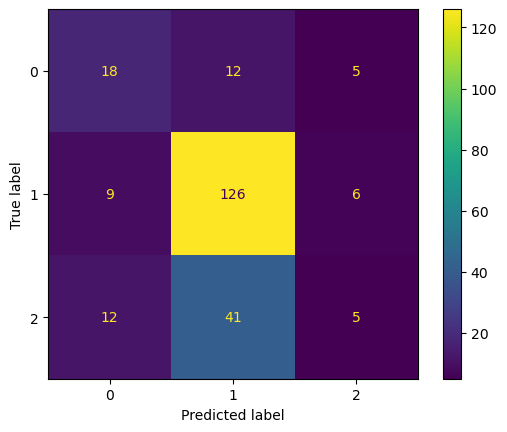

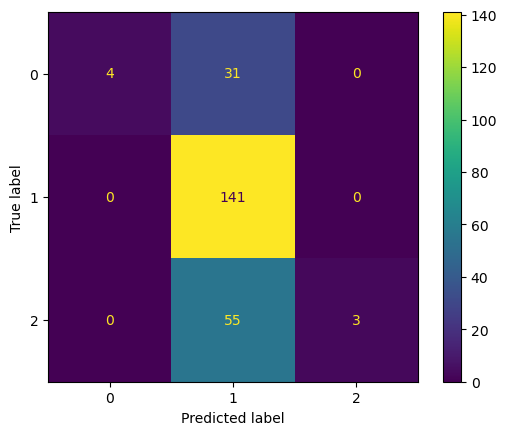

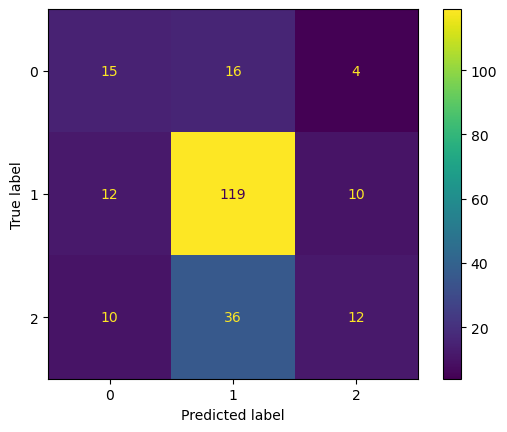

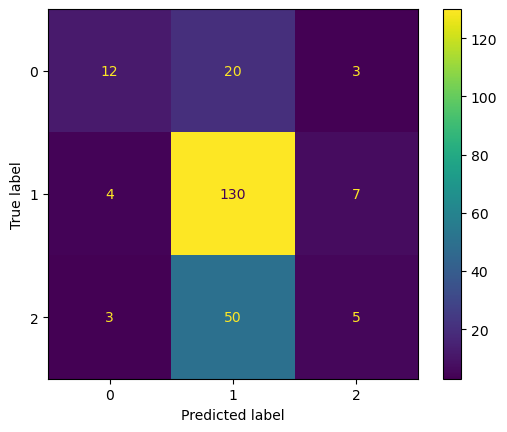

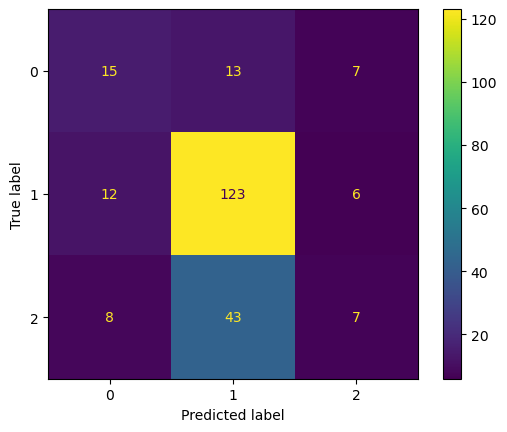

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

for clf, name in zip(trained, names):
    y_pred = clf.predict(X_test)
    print("\n" + name)
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

## 0 = early
## 1 = late
## 2 = middle

Text(0.5, 1.0, 'Learning Curve')

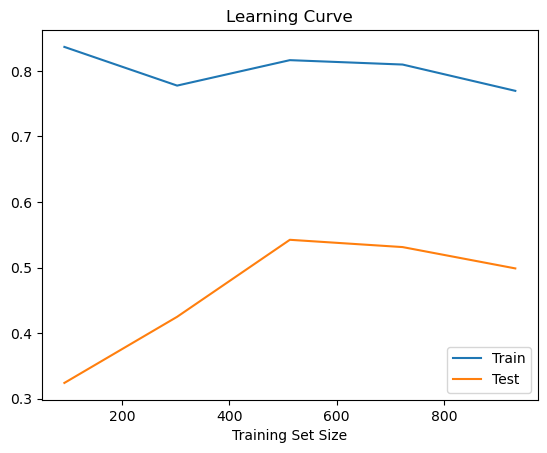

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(
    clf, X, y, cv=5, scoring="accuracy"
)

plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Train")
plt.plot(train_sizes, np.mean(test_scores, axis=1), label="Test")
plt.legend()
plt.xlabel("Training Set Size")
plt.title("Learning Curve")